## Neighbourhood clustering (numeric labels)

This tutorial extends the **Neighbourhood clustering (categorical labels)** notebook by demonstrating how to incorporate numeric (continuous) labels into neighbourhood clustering using MuSpAn.
For an overview of the general neighbourhood clustering workflow and its MuSpAn implementation, **please refer to the Neighbourhood clustering (categorical labels) tutorial**.

In biomedical spatial data (and other domains), measurements are often numeric — for instance, transcript counts or fluorescence intensity per cell. A concrete example is the 10x Visium HD platform, which provides gene expression measurements across spatial spots in a tissue section.

In the context of neighbourhood clustering, such continuous measurements can be used to define a spatial phenotype — a quantitative representation of each neighbourhood’s molecular characteristics. In this tutorial, we demonstrate how to use multiple continuous labels within a spatial domain to define neighbourhood-level features.

---

We’ll begin by loading an example Visium dataset from a stage 2 mouse colon cancer sample. This dataset includes topics representing gene expression signatures — analogous to cell types, but expressed as numeric values that quantify how strongly each spot corresponds to a given gene signature.

Let’s start by visualising a few of these topics on the spatial data.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Visium-Colon-Adenocarcinoma
Number of objects: 6487
Collections: ['Spots']
Labels: ['Barcode', 'Spot cluster', 'Spot diameter', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16'] 
Networks: [] 
Distance matrices: []


(<Figure size 1000x1000 with 8 Axes>, <Axes: >)

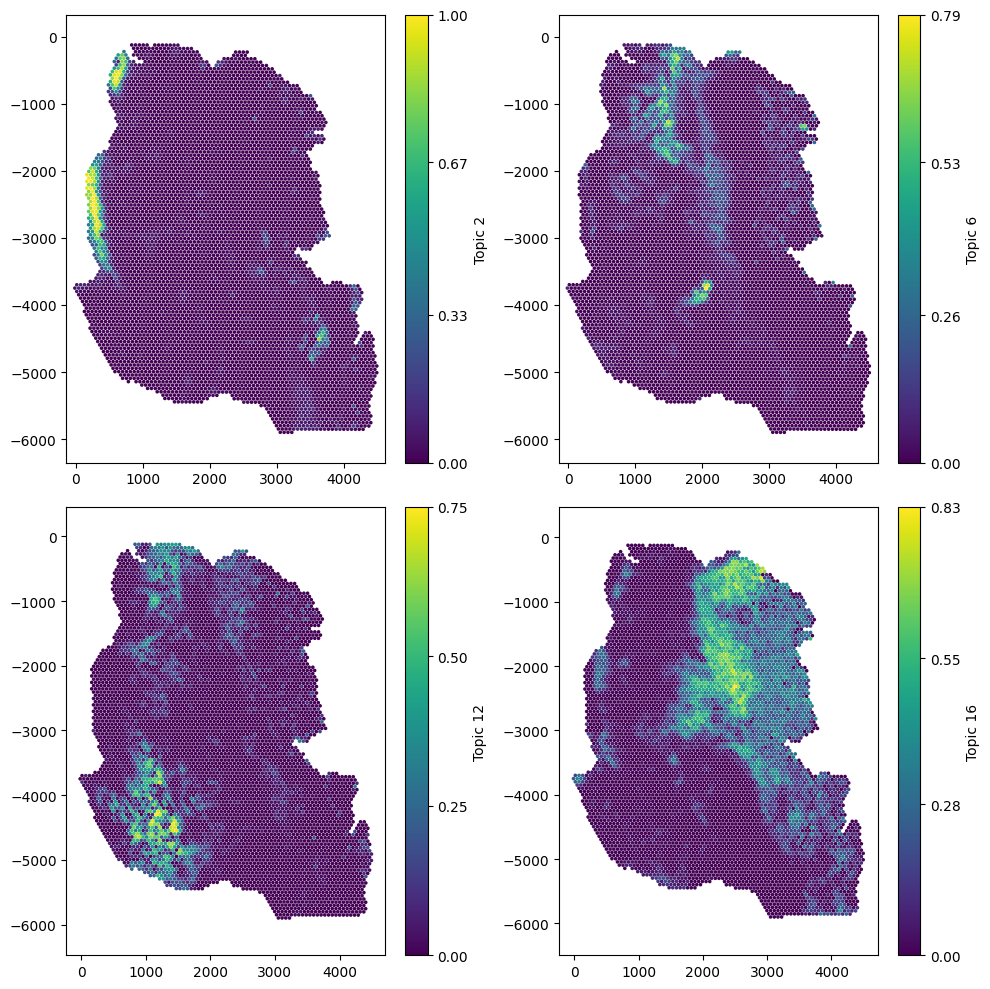

In [1]:
# Import necessary libraries
import muspan as ms
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

# Load the example domain dataset
example_domain = ms.datasets.load_example_domain('Visium-Colon-Adenocarcinoma')

# Set up the figure and axes for visualization
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Visualize different topics in the example domain
ms.visualise.visualise(example_domain, 'Topic 2', ax=ax[0, 0], marker_size=2.5)
ms.visualise.visualise(example_domain, 'Topic 6', ax=ax[0, 1], marker_size=2.5)
ms.visualise.visualise(example_domain, 'Topic 12', ax=ax[1, 0], marker_size=2.5)
ms.visualise.visualise(example_domain, 'Topic 16', ax=ax[1, 1], marker_size=2.5)

Now we can see the spatial variability of Topic signatures, we will need to choose a network to decide the connectivity of the spots. The domain as a label that gives the spot diameter, let's print this out.

In [2]:
# Print labels for the spot diameter - this is to see how large our network edges distances should be 
example_domain.print_labels('Spot diameter')


           Spot diameter
object_id               
0.0           219.358065
1.0           219.358065
2.0           219.358065
3.0           219.358065
4.0           219.358065
...                  ...
6482.0        219.358065
6483.0        219.358065
6484.0        219.358065
6485.0        219.358065
6486.0        219.358065

[6487 rows x 1 columns]


So we can see the diameter of the spots is around 220µm, we can use this to correctly define the direct adjacency of the spots in this sample. That is, let's use a Delaunay network model with a 3-hop region to define the neighbouhood for each spot.

**Important:** The way we tell `cluster_neighbourhoods` to use numeric labels is to pass the label names we'd like to use in a **list**, and pass this this to the `label_name` parameter. Before calling `cluster_neighbourhoods`, we'll quickly make this list for all our 'Topic' numeric labels.

In [3]:
# get a list of all numeric labels we want to use for neighbourhood clustering - these are the topic labels
numeric_labels = [f'Topic {i}' for i in range(1,17)]

# Perform cluster neighbourhood analysis
neighbourhood_enrichment_matrix,label_categories,cluster_categories=ms.networks.cluster_neighbourhoods(example_domain,
                                   label_name=numeric_labels,
                                   network_kwargs=dict(network_type='Delaunay',max_edge_distance=220),
                                   k_hops=3,
                                   transform_neighbourhood_composition='sqrt',
                                   neighbourhood_label_name='Neighbourhood ID',
                                   cluster_method='kmeans',
                                   cluster_parameters=dict(n_clusters=9),
                                   neighbourhood_enrichment_as='zscore')

Now we've generated our spatially resolved labels using our numeric labels called here 'Neighbourhood ID', we can take a look at what these actually represent in terms of the Topics we gave to the function.

Namely, we can use the `neighbourhood_enrichment_matrix` to produce a clustered heatmap of Topic expression per neighbourhood group, similar to the Neighbourhood clustering (categorical labels) tutorial**.

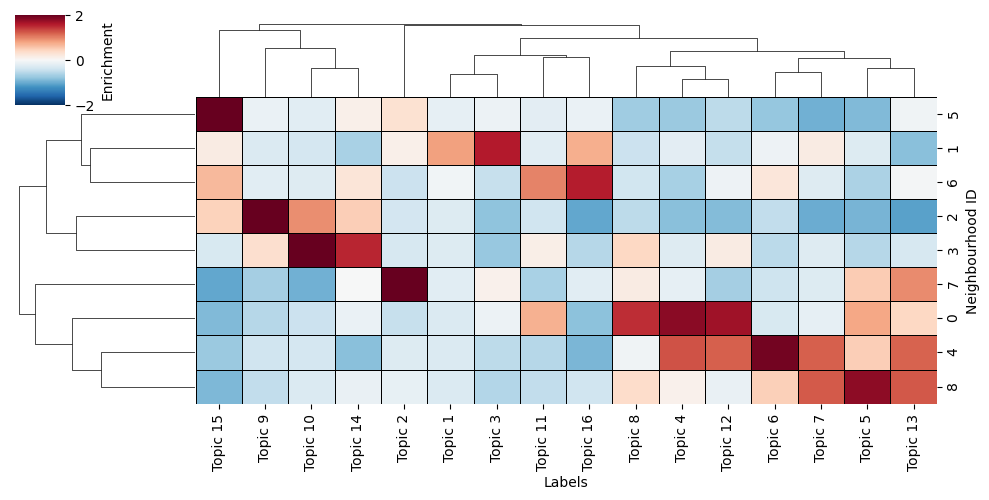

In [4]:
# this is simply visualising the neighbourhood enrichment matrix as a clustermap    

# Create a DataFrame from the neighbourhood enrichment matrix
df_ME_id = pd.DataFrame(data=neighbourhood_enrichment_matrix, index=cluster_categories, columns=label_categories)
df_ME_id.index.name = 'Neighbourhood ID'
df_ME_id.columns.name = 'Labels'

# Visualize the neighbourhood enrichment matrix using a clustermap
sns.clustermap(
    df_ME_id,
    xticklabels=label_categories,
    yticklabels=cluster_categories,
    figsize=(10, 5),
    cmap='RdBu_r',
    col_cluster=True,
    row_cluster=True,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, label='Enrichment', ticks=[-2, 0, 2]),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0.5, 'color': 'black'}
)

In addition, as these neighbourhood clusters get added as labels to the objects, we can view them on this tissue directly by visualising with the 'Neighbourhood ID' label name.

(<Figure size 1000x800 with 2 Axes>, <Axes: >)

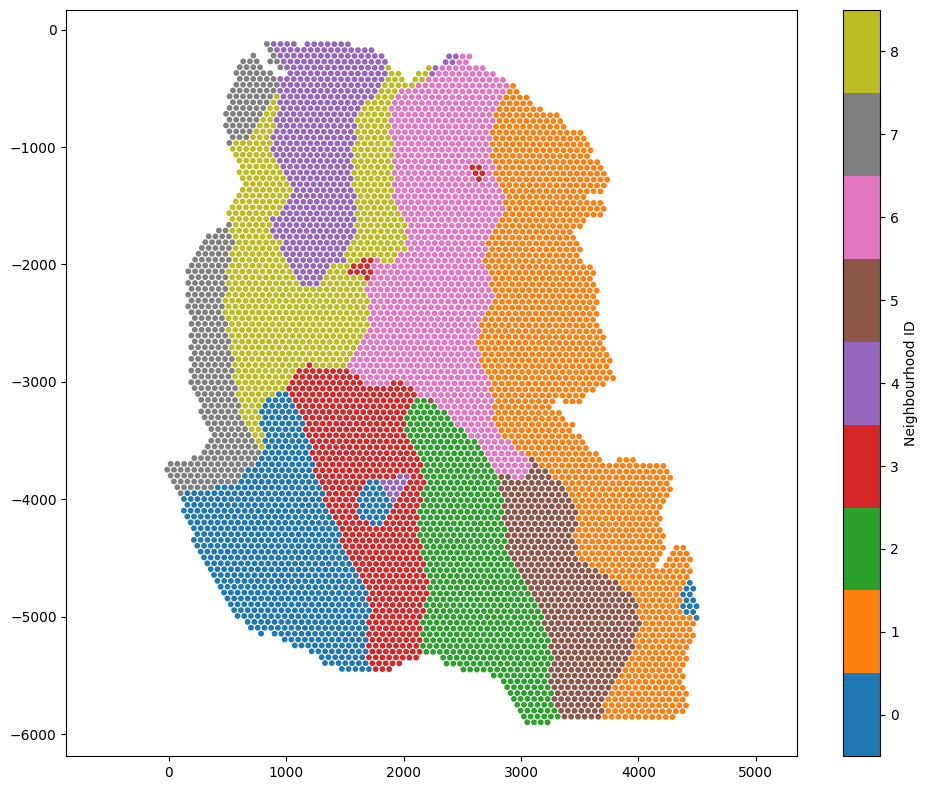

In [5]:
# visualise the neighbourhood clusters on the spatial domain
ms.visualise.visualise(example_domain,'Neighbourhood ID',marker_size=10)


We've generated a spatially resolved categorical label using our numeric (continuous) Topic labels. This new label can be used for futher spatial analysis within MuSpAn and beyond.

---

**Tip: Choosing clustering method and parameters**

The function `cluster_neighbourhoods` can return the **observation matrix** used for clustering by setting the parameter `return_observation_matrix=True`.  

This is useful when you want to experiment with different clustering methods or parameters. Once you have the observation matrix, you can explore clustering options using your preferred tools — for example, algorithms from **scikit-learn**. After identifying a suitable method and parameter set, you can pass those settings back into `cluster_neighbourhoods` for final clustering.

Additionally, the observation matrix can be used to **visualise neighbourhood relationships** or **inspect feature structure**, for instance by applying **UMAP** or **PCA** when working with high-dimensional features.

For more details, see the documentation for `cluster_neighbourhoods`.